In [13]:
import pandas as pd
import numpy as np
import glob
from os import walk

In [2]:
TRAIN_DATA_DIR = "./data/cropped_images"
TRAIN_LABELS_PATH = "./data/labels.txt"

In [29]:
labels = pd.read_csv(TRAIN_LABELS_PATH, sep=" ", header=None)[0].to_numpy()
d = {'label':labels}
labels = pd.DataFrame(d)
labels

label
0              without_mask
1                 with_mask
2              without_mask
3                 with_mask
4                 with_mask
...                     ...
4067              with_mask
4068              with_mask
4069  mask_weared_incorrect
4070              with_mask
4071              with_mask

[4072 rows x 1 columns]

In [34]:
labels.value_counts()

label                
with_mask                3232
without_mask              717
mask_weared_incorrect     123
dtype: int64

In [10]:
classes = np.unique(labels)
classes

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype=object)

In [28]:
filenames = []
for i in range(len(labels)):
    filenames.append(str(i) + '.png')
d = {'file_name':filenames}
filenames = pd.DataFrame(d)

file_name
0        0.png
1        1.png
2        2.png
3        3.png
4        4.png
...        ...
4067  4067.png
4068  4068.png
4069  4069.png
4070  4070.png
4071  4071.png

[4072 rows x 1 columns]

In [30]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(filenames,labels,test_size=0.20,stratify=labels,random_state=42)

In [32]:
print(X_train.shape,X_test.shape)

(3257, 1) (815, 1)


In [33]:
Y_train.value_counts()

label                
with_mask                2585
without_mask              574
mask_weared_incorrect      98
dtype: int64

In [35]:
X_train['label']=Y_train
X_test['label']=Y_test

C:\Users\Piotrek\AppData\Local\Temp/ipykernel_1696/91195937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['label']=Y_train
C:\Users\Piotrek\AppData\Local\Temp/ipykernel_1696/91195937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['label']=Y_test


In [39]:
X_test

file_name         label
1660  1660.png     with_mask
2976  2976.png     with_mask
920    920.png     with_mask
3984  3984.png     with_mask
3867  3867.png     with_mask
...        ...           ...
530    530.png     with_mask
1344  1344.png     with_mask
1756  1756.png     with_mask
1196  1196.png  without_mask
364    364.png     with_mask

[815 rows x 2 columns]

In [164]:
from keras_preprocessing.image import ImageDataGenerator

image_target_size = (int(128), int(128))

train_image_generator = ImageDataGenerator(rescale = 1. / 255.)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_train,
    directory = TRAIN_DATA_DIR,
    x_col = 'file_name',
    y_col = 'label',
    subset = 'training',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

Found 3257 validated image filenames belonging to 3 classes.


In [165]:
class_ind=train_generator.class_indices
class_ind

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

In [166]:
test_image_generator = ImageDataGenerator(rescale = 1. / 255.)

test_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_test,
    directory = TRAIN_DATA_DIR,
    x_col = 'file_name',
    y_col = 'label',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

Found 815 validated image filenames belonging to 3 classes.


In [167]:
train_generator.class_indices

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

In [145]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
input_tensor = Input(shape=(128, 128, 3))
mobileNet = MobileNetV2(weights="imagenet", include_top=False,input_tensor=input_tensor)

In [146]:
from tensorflow.keras.layers import AveragePooling2D

In [150]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

x = mobileNet.output
x = AveragePooling2D(pool_size=(4, 4))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(3,activation='softmax')(x)
model = keras.Model(inputs=mobileNet.input, outputs=outputs)

In [151]:
for layer in mobileNet.layers:
    layer.trainable = False

In [152]:
model.compile(loss = 'categorical_crossentropy',
                optimizer = keras.optimizers.Adam(lr=0.001),
                metrics = ['accuracy'])

history_1 = model.fit(train_generator, epochs = 15, steps_per_epoch = len(train_generator),
                     validation_data = test_generator, validation_steps = len(test_generator))

Epoch 1/15
102/102 [==============================] - 31s 277ms/step - loss: 0.5791 - accuracy: 0.8001 - val_loss: 0.4123 - val_accuracy: 0.8466
Epoch 2/15
102/102 [==============================] - 27s 270ms/step - loss: 0.4334 - accuracy: 0.8342 - val_loss: 0.3737 - val_accuracy: 0.8466
Epoch 3/15
102/102 [==============================] - 28s 271ms/step - loss: 0.3859 - accuracy: 0.8505 - val_loss: 0.3362 - val_accuracy: 0.8847
Epoch 4/15
102/102 [==============================] - 28s 270ms/step - loss: 0.3585 - accuracy: 0.8591 - val_loss: 0.3520 - val_accuracy: 0.8540
Epoch 5/15
102/102 [==============================] - 28s 273ms/step - loss: 0.3224 - accuracy: 0.8806 - val_loss: 0.3561 - val_accuracy: 0.8503
Epoch 6/15
102/102 [==============================] - 27s 270ms/step - loss: 0.3080 - accuracy: 0.8766 - val_loss: 0.3010 - val_accuracy: 0.8798
Epoch 7/15
102/102 [==============================] - 30s 291ms/step - loss: 0.2779 - accuracy: 0.8870 - val_loss: 0.2870 - val_ac

In [162]:
model.save('face_mask_detection2.h5')

In [163]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_17[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 16, 16, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 16, 16, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 16, 16, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 16, 16, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 8, 8, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 8, 8, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 8, 8, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 8, 8, 96)    384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 8, 8, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 8, 8, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 8, 8, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 4, 4, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 4, 4, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 4, 4, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 4, 4, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [154]:
score = model.evaluate(test_generator)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

26/26 [==============================] - 6s 213ms/step - loss: 0.2541 - accuracy: 0.9117
Test loss: 0.2540619671344757 / Test accuracy: 0.9116564393043518


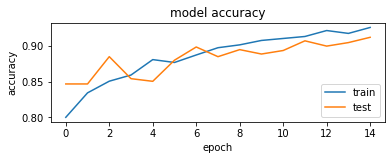

In [172]:
from matplotlib import pyplot as plt
plt.subplot(2,1,1)
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

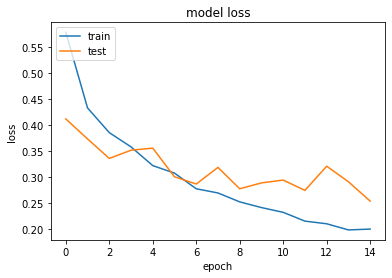

In [174]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()